In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline


In [2]:
train_set = pd.read_csv('./archive/train.csv')

# Adding a target variable to the testing eset
test_set['Target'] = None

# One additional we could do is to concantate the training and testing data
all_data = pd.concat((train_set, test_set), axis=0)

# Storing the predictor value
y_pred = all_data['Target']

# Storing the household leaders (there's one household leader per family)
heads = all_data.loc[all_data['parentesco1'] == 1].copy()

# Labels for training, the values we will to train the model (the predictor for the training and testing)
train_labels = all_data.loc[(all_data['Target'].notnull()) & (all_data['parentesco1'] == 1), ['Target', 'idhogar']]

In [3]:
# Shape of the training and testing set
train_set.shape, test_set.shape, all_data.shape

((9557, 143), (23856, 143), (33413, 143))

In [4]:
# More specific info on the training set
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [5]:
# More specific info on the testing set
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(129), object(6)
memory usage: 26.0+ MB


In [6]:
# Quick insight to the shape of the data
all_data.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Analyze: dtypes

### dtype: int64

In [7]:
def plot_nuniques_dtypes(data, d_type=np.int64):
    """Returns how many unique values for each numerical column"""
    
    data.select_dtypes(d_type).nunique().value_counts().sort_index().plot.bar(
        color='blue', figsize=(10,6), edgecolor="k", linewidth=3)
    plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
    plt.title('Count of Unique Values in Integer Columns')

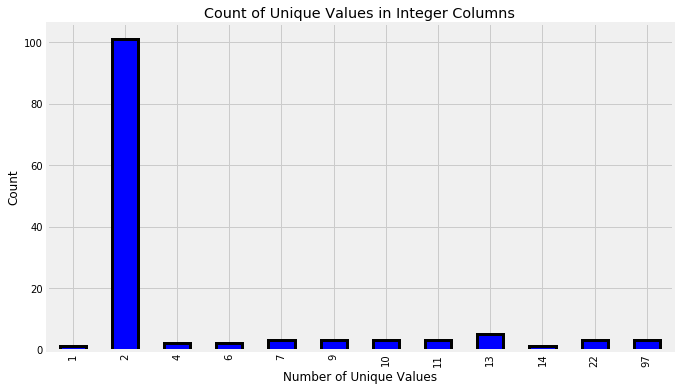

In [8]:
plot_nuniques_dtypes(train_set)

Notes:
- As we will notice, some of values not to be aggregated (since they are already at the household level).
- However, there will be other columns that will have to be aggregated since they are an individual level.

### dtype: float

In [9]:
# Mapping the values of floating columns
from collections import OrderedDict

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

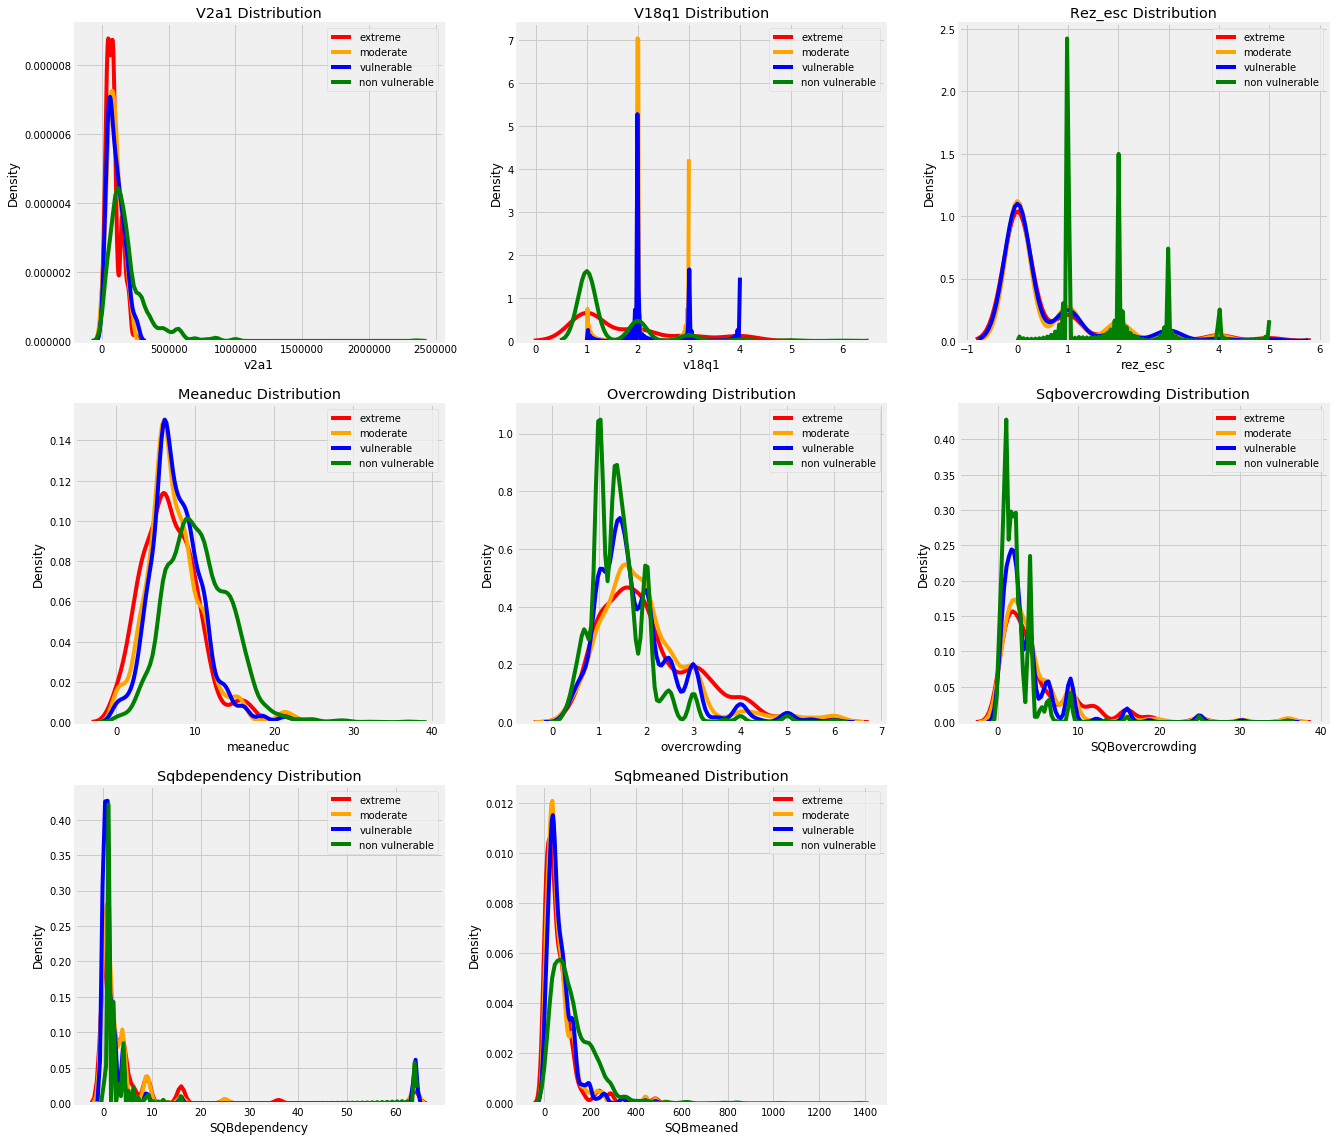

In [10]:
plt.figure(figsize=(20, 8))

# Iterate through the float columns
for i, col in enumerate(train_set.select_dtypes('float')):
    ax = plt.subplot(3, 3, i + 1)

    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        
        # Plot each poverty level as a separate line
        sns.kdeplot(train_set.loc[train_set['Target'] == poverty_level, col].dropna(), 
                    ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top=2)

### dtype: object

In [11]:
train_set.select_dtypes('object').head(5)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Notes:
- Noticed that there's a mixture of integers and strings for the later 3 columns.
- The documenation assigns yes or no to 1 or 0 

In [12]:
# Reshaping the mixed values for object
mapping_incorrections = {'yes': 1, 'no': 0}

# Reshaping the data based on replace the yes and no
for df in [train_set, test_set, all_data]:
    for col in ['dependency', 'edjefa', 'edjefe']:
        df[col] = df[col].replace(mapping_incorrections).astype(np.float64)

In [13]:
all_data[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,33413.000000,33413.000000,33413.000000
mean,1.172238,2.827822,5.170353
std,1.649249,4.606153,5.214174
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


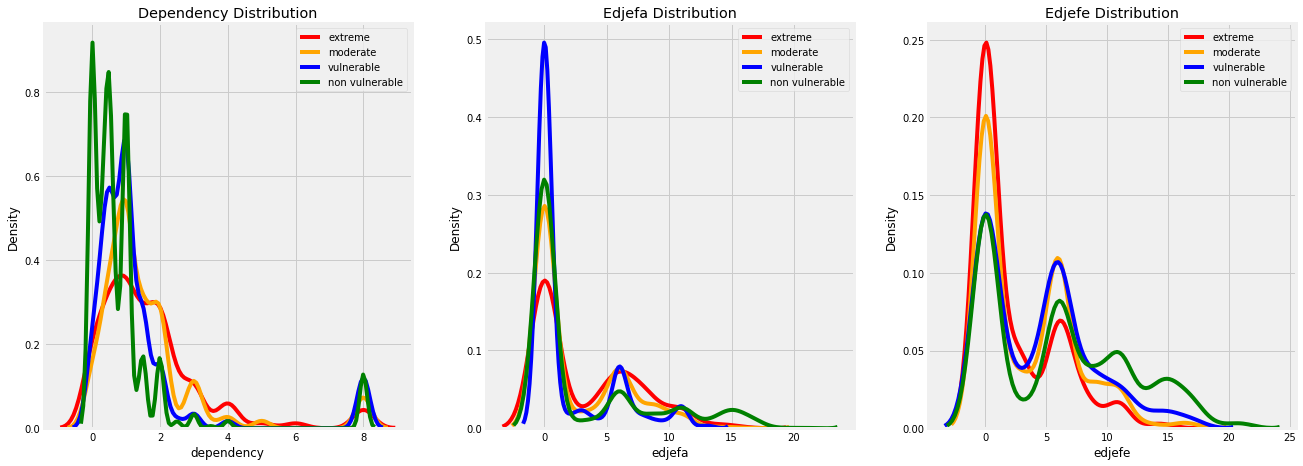

In [14]:
# Take a deeper closer in the three new added features
# A deeper distribution of the floating variables
plt.figure(figsize=(20, 3))

# Iterate through floats
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(1, 3, i + 1)
    
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        
        # Plot each poverty level as a separate line
        sns.kdeplot(train_set.loc[train_set['Target'] == poverty_level, col].dropna(), 
                    ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Notes
- The distribution among the four target variables are very similar. Thus, we cannot find too much information.

In [15]:
# SETTING UP VARIABLES THAT WILL BE USED
TARGET_AXIS_LABELS = ('non-vunerable hh', 'moderate pov', 'vunerable hh', 'extreme pov')

Text(0.5,1,'Poverty Level')

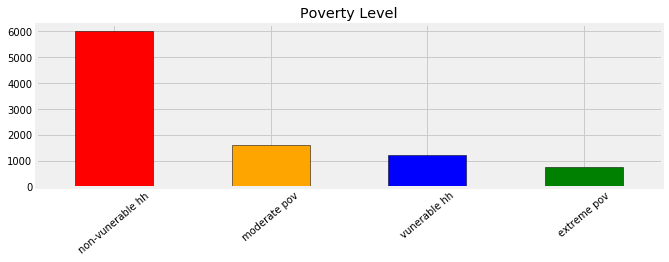

In [16]:
# Understanding the distribution of the target variable
plt_label_counts = train_set['Target'].value_counts().plot(kind="bar", figsize=(10,3), color=colors.values(),
                                                           edgecolor="k")
plt_label_counts.set_xticklabels(labels=TARGET_AXIS_LABELS, rotation=40)
plt.title("Poverty Level")


In [17]:
# Percentage of the target variable
def get_categorical_percent(data, target_label):
    """Returns the percentage of the target variables (could be any categorical column)"""
    total_sum = data[target_label].value_counts().sum()
    percents = []
    for i, target in enumerate(data[target_label].value_counts().sort_index()):
        percent = target/total_sum
        percents.append(f"Target {poverty_mapping[i+1]}: Percentage of {percent:.2f}")
    return percents

In [18]:
get_categorical_percent(train_set, "Target")

['Target extreme: Percentage of 0.08',
 'Target moderate: Percentage of 0.17',
 'Target vulnerable: Percentage of 0.13',
 'Target non vulnerable: Percentage of 0.63']

Notes
- Most of the values fall within the non-vunerable.
- Noticed that about 2/3 of the data is considered non-vunerable!

## Analyze: Errors

Notes:
- We need to have idhogars to be the same target for a household
- Unfortunately, for some families, target are not the same for the household (even with the same idhogar)
- Thus, we need to assign the target to all the member of the idhogar
- Using the head of the house's target variable

In [19]:
trgt_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
trgt_not_equal = trgt_equal[trgt_equal == False]

# The total amnt of mismatched values
len(trgt_not_equal)

85

In [20]:
# Example of a case:
train_set.loc[train_set["idhogar"] == trgt_not_equal.index[0], :]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
7651,ID_a5e2b0639,NaN,0,5,0,1,1,0,NaN,0,...,49,196,25,36,4,2.777778,0.444444,58.777775,196,3
7652,ID_5dfdf4ebe,NaN,0,5,0,1,1,0,NaN,0,...,100,289,25,36,4,2.777778,0.444444,58.777775,289,2
7653,ID_762e1fd96,NaN,0,5,0,1,1,0,NaN,0,...,36,2601,25,36,4,2.777778,0.444444,58.777775,2601,3
7654,ID_c76b87004,NaN,0,5,0,1,1,0,NaN,0,...,36,2304,25,36,4,2.777778,0.444444,58.777775,2304,3
7655,ID_1dffe3dcf,NaN,0,5,0,1,1,0,NaN,0,...,121,441,25,36,4,2.777778,0.444444,58.777775,441,2


In [21]:
# Another error with the data is if the household does not have a head leader
hh_head = train_set.groupby('idhogar')['parentesco1'].sum()

# Finding household without a head leader
hh_no_head = train_set.loc[train_set['idhogar'].isin(hh_head[hh_head == 0].index), :]
hh_no_head['idhogar'].nunique()

15

Notes:
- There are 15 households that have no head household member


In [22]:
# Are there values where there is no hh leader and the household have different target variables
hh_mistmatched = hh_no_head.groupby('idhogar')['Target'].apply(
    lambda x: x.nunique() == 1)

# There are no variables where we have a mismatch btw family members and no household leader
sum(hh_mistmatched == False)

0

In [23]:
# Updating the values where we house holds have different target variables
for target in trgt_not_equal.index:
    
    # Locate the true target from our series where targets are not equal among the same id_hogar
    # and the target that the head has
    true_target = int(train_set[(train_set['idhogar'] == target) 
                            & (train_set['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for the target
    train_set.loc[train_set['idhogar'] == target, "Target"] = true_target
    
# Let check if all household have the same target
all_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
not_equal = all_equal[all_equal==False]

# Its' an empty series, we fixed the problem
not_equal

Series([], Name: Target, dtype: bool)

## Cleaning Data

In [24]:
def get_dtypes(data, verbose=False):
    """Returns a list: numerical values, object-like columns"""
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics_cols = data.select_dtypes(include=numerics).columns
    object_cols = data.select_dtypes(include='object').columns
    if verbose:
        print('There are {0} numeric cols: {1}\nThere are {2} object cols: {3}\nThere are total cols: {4}'.format
              (len(numerics_cols),numerics_cols, len(object_cols), object_cols, len(data.columns)))
    return [numerics_cols, object_cols]

def get_missing_values(data, cols):
    """Returns a dataframe with missing values (in absolute and percentage format)"""
    
    missing_percent = data[cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    missing_abs = data[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    df = pd.DataFrame({'Missing': missing_abs, 'Percent': missing_percent})
    
    # Removing zero values
    df = df.loc[~(df==0).all(axis=1)]
    return df

def plot_value_counts(df, col, heads_only=False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (5, 5))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

In [25]:
# Separting the numeric and object columnac
num_cols, obj_cols = get_dtypes(all_data, verbose=False)

In [26]:
nums_missing = get_missing_values(all_data, num_cols)
nums_missing

,Missing,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
meaneduc,36,0.001077
SQBmeaned,36,0.001077


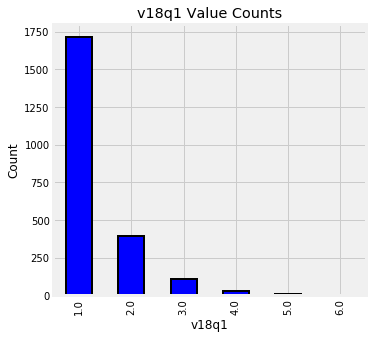

In [27]:
# Missing value: v18q1
plot_value_counts(heads, 'v18q1')

Notes:
- We CANNOT conclude that we should replace the missing values with 1.
- Since, the family might not own a tablet (thus, we would replace the missing data with 0)
- We need to check the binary column ('v18q') to further investigate the missing value

In [28]:
# We need to group the heads dataframe with v18q and see the null values 
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Notes:
- Notice that all values that are 0 in the v18q column (binary if a person owns a tablet), for every value that v18q1 is null, it is also label as 0

In [29]:
# Filling in the missing value
all_data['v18q'] = all_data['v18q'].fillna(0)

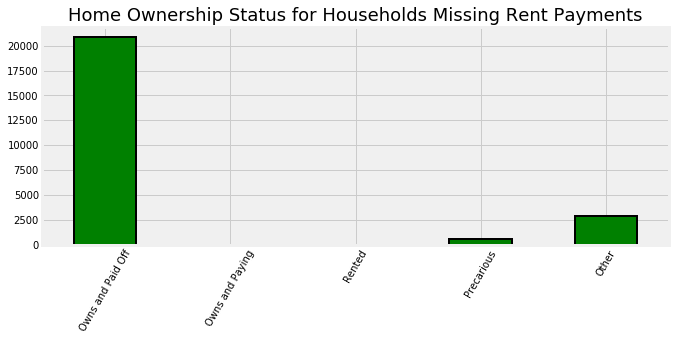

In [30]:
# Missing value: v18q1
# v18q1 is monthly payment, thus, we should look at property ownership
ownership_cols = [x for x in all_data if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent payments
all_data.loc[all_data['v2a1'].isnull(), ownership_cols].sum().plot.bar(figsize = (10, 4),
                                                                       color = 'green',
                                                                       edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'], rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

Notes: 
- For the most part, we answered the problem. People who had missing payment meant that they own the property.
- However, there are still values that indicate missing values.


In [31]:
# Updating the payment to 0 for people who own the property
all_data.loc[(all_data['v2a1'].isnull()) & (all_data['tipovivi1'] == 1), "v2a1"] = 0

# Creating an additional boolean values of people who have missing values
all_data['v2a1-missing'] = all_data['v2a1'].isnull()
all_data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [32]:
# Missing Value: rez_esc (years behind in school)

# Checking the age of people who have null values as years behind in school
all_data.loc[all_data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [33]:
# Will need to compare this with values that are not null
all_data.loc[all_data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

Notes:
- You cannot be years in school if you are not in school. 
- Thus, we can make this value 0 if you are younger than 7 or older than 19 

In [34]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
all_data.loc[((all_data['age'] > 19) | (all_data['age'] < 7)) & (all_data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
all_data['rez_esc-missing'] = all_data['rez_esc'].isnull()

# Notice that there is an outlier
print(all_data['rez_esc'].value_counts())
all_data.loc[all_data['rez_esc'] > 5, 'rez_esc'] = 5

0.0     30894
1.0       728
2.0       336
3.0       174
4.0        80
5.0        39
99.0        1
Name: rez_esc, dtype: int64


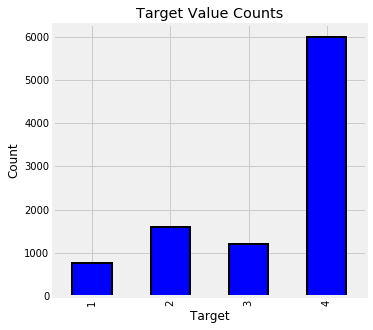

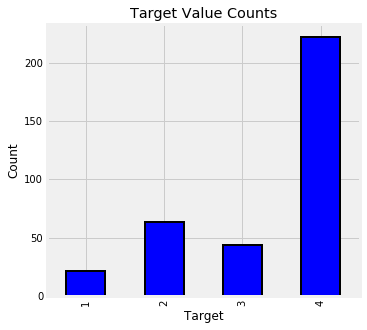

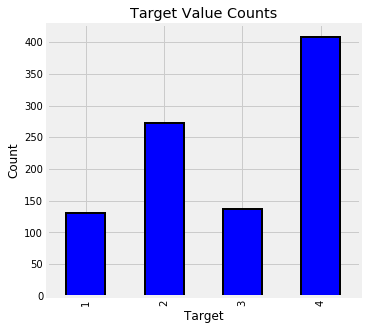

In [35]:
# Understanding how the data is related with and with not the missing values 
plot_value_counts(all_data, 'Target')
plot_value_counts(all_data[all_data['rez_esc-missing'] == 1], 'Target')
plot_value_counts(all_data[all_data['v2a1-missing'] == 1], 'Target')

Notes:
- Noticed that the distriution for the rez_esc_missing has a similar dist. as the data. However, the v2a1-missing has a different dist. than the data
- The missing information can be just as valuable as the data.

In [40]:
# For the feature engingerring check: Analysis_02

# Saving the sets for future use
all_data.to_pickle("./pickles/all_data.pkl")
test_set.to_pickle("./pickles/test.pkl")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickles
plt.style.use('fivethirtyeight')
%matplotlib inline


In [2]:
all_data = pd.read_pickle("./pickles/all_data.pkl")

A concise format of how to approach the grouping. (I did manage to this without much guidance). But I do appreciate this workbook is able to consisely explain the process I followed.

Define Variable Categories

There are several different categories of variables:

Individual Variables: these are characteristics of each individual rather than the household
- Boolean: Yes or No (0 or 1)
- Ordered Discrete: Integers with an ordering

Household variables
- Boolean: Yes or No
- Ordered Discrete: Integers with an ordering

Continuous numeric
- Squared Variables: derived from squaring variables in the data
- Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [3]:
# Correctly labeling the data
# Unfortunaly, since the data cannot be structured, I think it's worthwhile to look at the data

# Ids
id_ = ['Id', 'idhogar', 'Target']

# Looking at individuals variables (meaning individuals in the same household should have diff. values)
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1', 
            'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 
            'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 'parentesco11', 
            'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 
            'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

# Looking at households variables
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 'paredpreb',
           'pisocemento', 'pareddes', 'paredmad','paredzinc', 'paredfibras', 'paredother', 
           'pisomoscer', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera','techozinc', 
           'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 
           'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 
           'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6', 'energcocinar1', 
           'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 
           'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 
           'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'tipovivi1', 'tipovivi2', 'tipovivi3', 
           'tipovivi4', 'tipovivi5', 'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = ['rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

# Storing the squared variables
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 
        'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']


In [4]:
# Double checking there are no repated variables and they are in the list
from collections import Counter

columns_x = id_ + ind_bool + ind_ordered + hh_bool + hh_cont + hh_ordered + sqr_
print('There are no repeated values', np.all(np.array(list(Counter(columns_x).values())) == 1))
print('We covered every variable: ', len(columns_x) == all_data.shape[1])


There are no repeated values True
We covered every variable:  True


## Analyze: Columns Type

### Squared Columns

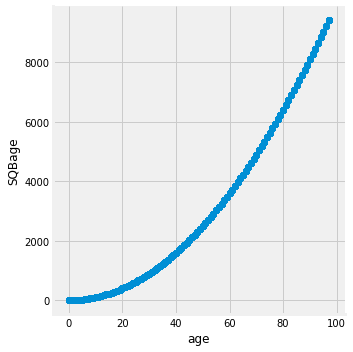

In [5]:
# As should be noted, there's a high correlation btw a values and its square value...
sns.lmplot('age', 'SQBage', data=all_data, fit_reg=False)

In [6]:
# Removing sq variables (they do not add any value since we have the original values)
all_data = all_data.drop(sqr_, axis=1)
all_data.shape

(33413, 136)

### Id Columns
- Id columns should be kept since we need to maintain the same structure

### Household Level Columns

In [7]:
# Subset of the household memebers and their variables
hh_vars = hh_bool + hh_cont + hh_ordered + id_
heads = all_data.loc[all_data['parentesco1'] == 1, hh_vars]
heads.shape

(10307, 99)

Notes:
- We do not need to make much adjustments. However, we could look at values that are too redundant.

In [8]:
def get_corrs_matrix(data, corr_threshold=0.95):
    """ Returns a list: correlation matrix, columns to drop based on the correlation threshold"""
    corr_matrix = data.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(abs(upper[c]) > corr_threshold)]
    return [corr_matrix, to_drop]


In [9]:
corr_matrix, corr_values = get_corrs_matrix(heads)
corr_values

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [10]:
# dataframes that have a high correlation with the correlation values we found above
for drop in corr_values:
    corr_df = corr_matrix.loc[corr_matrix[drop].abs() > 0.9, corr_matrix[drop].abs() > 0.9]
    print(corr_df)


           public   coopele
public   1.000000 -0.967759
coopele -0.967759  1.000000
       area1  area2
area1    1.0   -1.0
area2   -1.0    1.0
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3       

Notes:
- Perfect correlated values are 
    - hhsize & tmhog
    - hogar_total & hhsize
    - area1 & area2
- Highly correlated values are
    - r4t3 & hhsize
    - r4t3 & hogar_total
    
    
- r4t3, Total persons in the household
- tamhog, size of the household
- tamviv, number of persons living in the household
- hhsize, household size
- hogar_total, # of total individuals in the household

Notice that tamhog, hhsize, and hogar_total are the same variables (could drop two of these)

tamviv does not represent the same as the other values because it indicates how may people are actually in the household. Meaning, we could have more members in the household than the household

In [11]:
# Removing 'tamhog', 'hogar_total', 'r4t3'
heads.drop(['tamhog', 'hogar_total', 'r4t3'], inplace=True, axis=1)

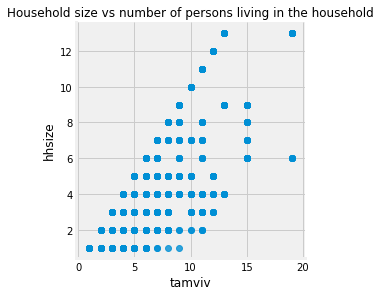

In [12]:
# Visualize hhsize and tamviv
# hhsize is not the same tamviv 
# There could be more people living in a household than the family

sns.lmplot('tamviv', 'hhsize', all_data, fit_reg=False, size=4);
plt.title('Household size vs number of persons living in the household', fontdict={'fontsize': 12});

In [13]:
# Thus, the difference could provide some insight

heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
heads['hhsize-diff'].value_counts()

0     9901
1       98
2       90
3       84
4       61
5       28
6       14
7       11
8       11
9        8
13       1
Name: hhsize-diff, dtype: int64

In [14]:
# Correlated Values: coopele
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
heads.drop(['noelec', 'coopele', 'public', 'planpri'], axis=1, inplace=True)

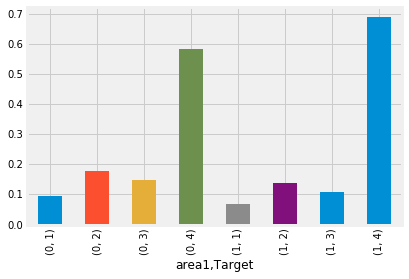

In [15]:
# The final redundant column is area2. 
# This means the house is in a rural zone, but it's redundant because 
# we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.
heads.drop(['area2'], axis=1, inplace=True)

# Observe how area affects the target variables
heads.groupby('area1')['Target'].value_counts(normalize=True).sort_index().plot(kind="bar")

Notes:
- It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

## Data Enginnering: Feature Creation

### Ordinal Variables

In [16]:
def get_similar_cols(data, groupby_format):
    """Returns columns that follow a similar groupby_format"""
    return data.filter(like=groupby_format, axis=1).columns.tolist()

In [17]:
# Wall Ordinal Variables

walls_columns = get_similar_cols(all_data, groupby_format='epared')
heads['walls'] = np.argmax(np.array(heads[walls_columns]), axis=1)
heads.drop(walls_columns, axis=1, inplace=True)

In [18]:
# Roof Ordinal Variables

roof_columns = get_similar_cols(all_data, groupby_format='etecho')
heads['roof'] = np.argmax(np.array(heads[roof_columns]), axis=1)
heads.drop(roof_columns, axis=1, inplace=True)

In [19]:
# Floor Ordinal Variables

floor_columns = get_similar_cols(all_data, groupby_format='eviv')
heads['floor'] = np.argmax(np.array(heads[floor_columns]), axis=1)
heads.drop(floor_columns, axis=1, inplace=True)

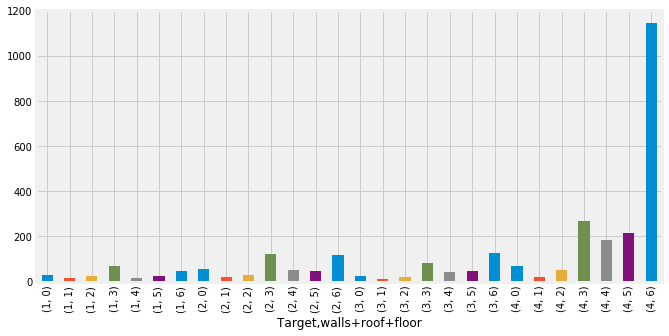

In [20]:
# Create new feature

plt.figure(figsize = (10, 5))
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']
heads.groupby('Target')['walls+roof+floor'].value_counts().sort_index().plot(kind="bar")

Notes:
- This new feature may be useful because it seems like a Target of 4 (the lowes poverty level) tends to have higher values of the 'house quality' variable. 

In [21]:
# Percentage of the each target for each ordinal wall+roof+floor value

counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(
    normalize=True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head(5)

,walls+roof+floor,Target,Normalized Count
0,0,4,0.376404
1,0,2,0.320225
2,0,1,0.162921
3,0,3,0.140449
4,1,4,0.323529


In [22]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + (heads['elec'] == 0) + 
                        heads['pisonotiene'] + heads['abastaguano'] + 
                        (heads['cielorazo'] == 0))

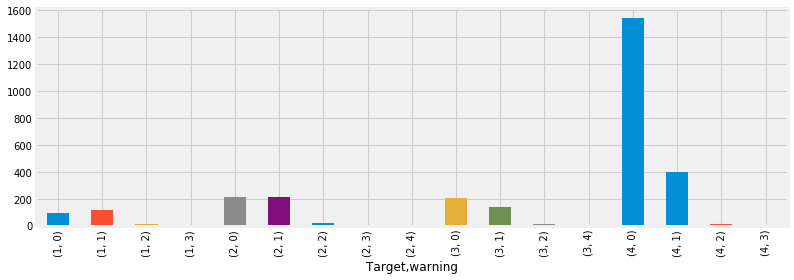

In [23]:
# Plotting the warning variable
plt.figure(figsize = (12, 4))
heads.groupby('Target')['warning'].value_counts().sort_index().plot(kind="bar")

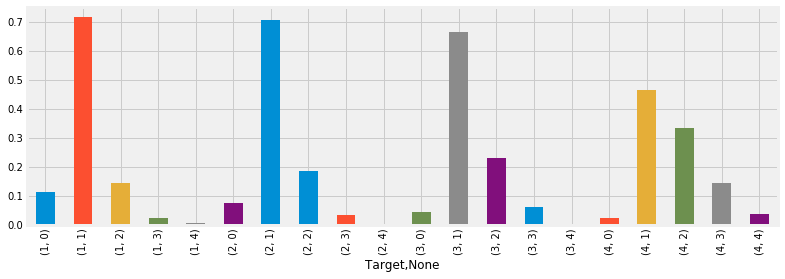

In [24]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])
# Plotting the bonus variable
plt.figure(figsize=(12,4))
heads.groupby('Target')['bonus'].apply(lambda x: x.value_counts()/len(x)).sort_index().plot(kind="bar")

In [25]:
# Lastly, creating some percentage values
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Data Analysis

### Household Variables
There are a numerous method to measure to relationship btw two variables:
- The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables 
- The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables
- The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.


Pearson Correlation Guidelines:
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [26]:
# Only focusing on the training set
heads_train = heads.loc[heads['Target'].notnull(), :].copy()
heads_train['Target'] = heads_train['Target'].astype('int64')
pcorrs = pd.DataFrame(heads_train.corr()['Target'].sort_values(ascending=False)).rename(columns=
                                                                        {"Target": 'P_corr'}).reset_index()

# Top positive correlated Values
pcorrs = pcorrs.rename(columns={'index': 'feature'})
pcorrs.head(6)[1:]

,feature,P_corr
1,meaneduc,0.333652
2,walls+roof+floor,0.332446
3,floor,0.307605
4,phones-per-capita,0.299026
5,walls,0.298737


In [27]:
# Top negative correlated values
pcorrs.dropna().tail(5)

,feature,P_corr
87,r4m1,-0.209479
88,overcrowding,-0.234954
89,r4t1,-0.260917
90,hogar_nin,-0.266309
91,warning,-0.301791


Notes:
- Negative correlation: as we increase the value, poverty will increase. E.g. as our warning increases, the level of poverty will begin to decrease. 
- Overcrowing and hogar_nin (children under the age of 19) worsen poverty for households.
- For the positive values, walls, roof, and floor indicates that an improvement in those variables will eventually decrease poverty.


Spearman Correlation:

In [28]:
import warnings
from scipy.stats import spearmanr

warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(heads_train[c], heads_train['Target']).correlation)
        pvalues.append(spearmanr(heads_train[c], heads_train['Target']).pvalue)

# Top Positive correlated values
scorrs = pd.DataFrame({'feature': feats, 'S_corr': scorr, 'pvalue': pvalues}).sort_values('S_corr', ascending=False)
scorrs.head(5)

,feature,S_corr,pvalue
85,walls+roof+floor,0.338791,9.539346e-81
88,phones-per-capita,0.337377,4.760104e-80
84,floor,0.309638,4.466091e-67
22,cielorazo,0.300996,2.611808e-63
82,walls,0.298963,1.925370e-62


In [29]:
# Top negative correlated values
scorrs.dropna().tail(5)

,feature,S_corr,pvalue
7,pisocemento,-0.209387,8.270816e-31
69,r4t1,-0.219226,1.112230e-33
74,hogar_nin,-0.236225,5.567218e-39
57,dependency,-0.281516,2.792620e-55
86,warning,-0.307326,4.682829e-66


In [30]:
# Notice that both correlation matrix have identical values
# lets find their differences

corrs = pcorrs.merge(scorrs, on='feature')
corrs['diff'] = corrs['P_corr'] - corrs['S_corr']
corrs['abs_diff'] = np.abs(corrs['diff'])
corrs.sort_values(by='diff', ascending=False).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
77,dependency,-0.126465,-0.281516,2.792620e-55,0.155051,0.155051
31,edjefa,0.052310,0.005114,7.804715e-01,0.047197,0.047197
10,edjefe,0.235687,0.214736,2.367521e-32,0.020951,0.020951
46,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549,0.016549
39,techozinc,0.014357,0.003404,8.528369e-01,0.010954,0.010954


In [31]:
# Top difference variables for correlation
corrs.sort_values(by='diff', ascending=True).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
19,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119,0.071119
88,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691,0.041691
3,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351,0.038351
86,r4m1,-0.209479,-0.171953,3.649343e-21,-0.037526,0.037526
89,hogar_nin,-0.266309,-0.236225,5.567218e-39,-0.030084,0.030084


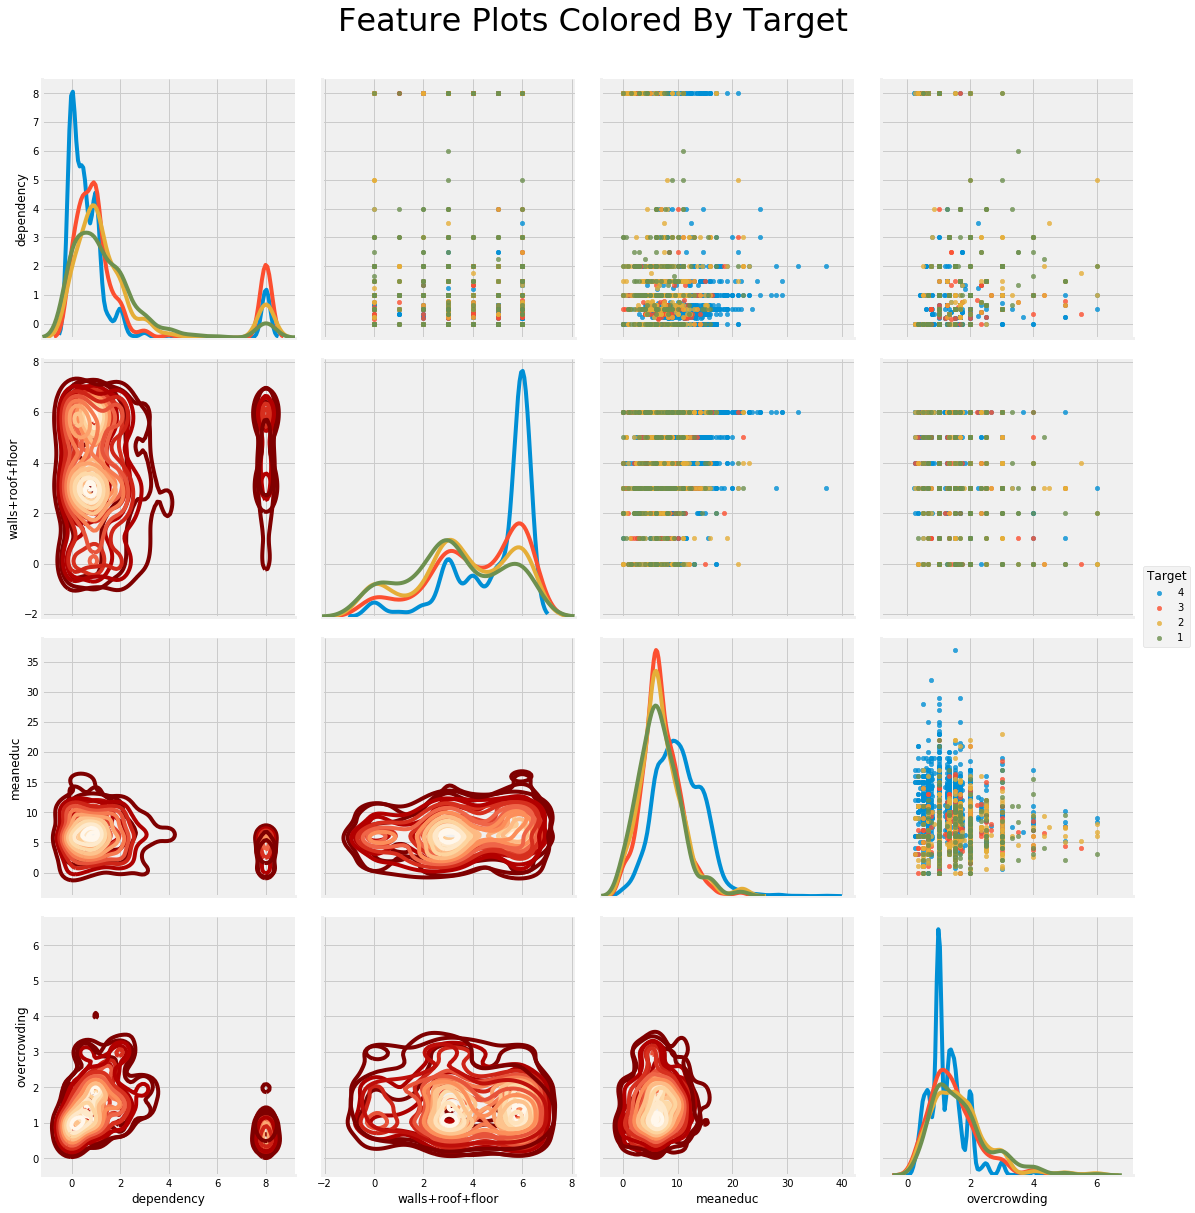

In [32]:
# Plotting plots/charts amongst the most correlated values

import warnings
warnings.filterwarnings('ignore')

# Chosen by the author of the workbook
plot_data = heads_train[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, size=4, diag_sharey=False,
                    hue='Target', hue_order=[4, 3, 2, 1], 
                    vars=[x for x in list(plot_data.columns) if x != 'Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y = 1.05);

In [33]:
# Storing the household columns
household_feats = list(heads.columns)

### Individial Variables

In [34]:
ind = all_data[id_+ind_bool+ind_ordered]
ind.shape

(33413, 40)

In [35]:
corr_matrix, corrs_to_drop = get_corrs_matrix(ind)
corrs_to_drop

['female']

In [36]:
# We already have the male variable, lets keep the female variables
ind.drop(['male'], axis=1, inplace=True)

In [37]:
instl_vars = get_similar_cols(ind, 'instl')
ind[instl_vars].head(5)

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


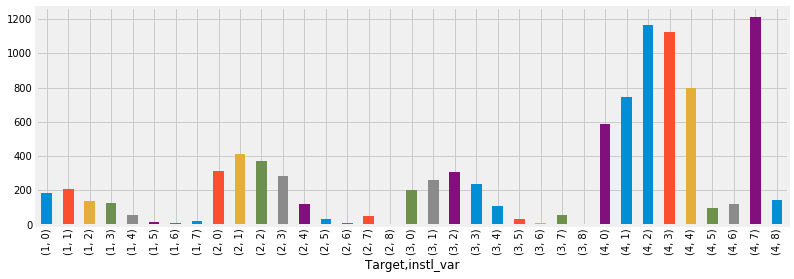

In [38]:
# Creating the ordinal columns with the variables from above

ind['instl_var'] = np.argmax(np.array(ind[[c for c in instl_vars]]), axis=1)
plt.figure(figsize=(12, 4))
ind.groupby('Target')['instl_var'].value_counts().sort_index().plot(kind="bar")
#.plot(kind='bar', )

Notes:
- Higher level of education can reduce poverty

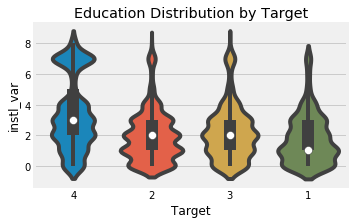

In [39]:
plt.figure(figsize = (5, 3))
sns.violinplot(x='Target', y='instl_var', data=ind);
plt.title('Education Distribution by Target');

In [40]:
ind.shape

(33413, 40)

## Data Engineering

In [41]:
# An important component woul dbe to find the ratio of specific metrics
# Normalizing the value to an apprioate metrics could be useful to find its improtance 

# The total number of schooling by age could reveal if their education has an important weight in their lvies
ind['escolari/age'] = ind['escolari']/ind['age']

# The level of education by their age
ind['instl_var/age'] = ind['instl_var']/ind['age']

# We can also calculate the years behind in school. Could they be old and still in school?
ind['rez_esc/age'] = ind['rez_esc']/ind['age']

In [42]:
# Other than ratio, we could find similar items
# e.g., we could at the tech gadgets in a household
ind['tech_gadgets'] = ind['mobilephone'] + ind['v18q']

### Feature Enginnering: Aggregations

In [43]:
# Creating the range functions
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'


# Group and aggregate
ind_agg = ind.drop(['Target'], axis=1).groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...   rez_esc/age  \
           min max sum count  std range_ min max sum count  ...           sum   
idhogar                                                     ...                 
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...           0.0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...           0.0   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...           0.0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...           0.0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...           0.0   

                            tech_gadgets                            
          count  std range_          min max sum count  std range_  
idhogar                                                             
000a08204     3  0.0    0.0            2   2   6     3  0.0      0  
000bce7c4     2  0.0    0.0            1   1   2     2  0.0      0  
001845fb0     3  0.0    0.0            1   1   4     4  0.0      0  
001ff74ca     1  NaN    0.0            2   2   4     2  0.0      0  
003123ec2     4  0.0    0.0            1   1   4     4  0.0      0  

[5 rows x 240 columns]

In [44]:
# Renaming the aggreagation columns
new_col = []
for col in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{col}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head(5)

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,rez_esc/age-sum,rez_esc/age-count,rez_esc/age-std,rez_esc/age-range_,tech_gadgets-min,tech_gadgets-max,tech_gadgets-sum,tech_gadgets-count,tech_gadgets-std,tech_gadgets-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.0,3,0.0,0.0,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.0,2,0.0,0.0,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.0,3,0.0,0.0,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.0,1,NaN,0.0,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.0,4,0.0,0.0,1,1,4,4,0.0,0


In [45]:
# Removing the variables that are redundant
corr_matrix, ind_agg_to_drop = get_corrs_matrix(ind_agg)
len(ind_agg_to_drop)

117

In [46]:
# Storing the individual variables
ind_agg = ind_agg.drop(ind_agg_to_drop, axis=1)
ind_feats = ind_agg.columns.tolist()

In [47]:
# Merging with household data
final_ = heads.merge(ind_agg, on='idhogar', how='left')

print("Shape of the final dataset is {}".format(final_.shape))

Shape of the final dataset is (10307, 218)


In [48]:
final_.head(5)

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-sum,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_
0,0,0,1,1,1,0,0,0,0,0,...,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,0,0,1,1,0,0,0,0,0,1,...,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,0,0,1,1,0,0,0,0,0,1,...,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,0,0,1,1,1,0,0,0,0,0,...,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,1,0,1,1,1,0,0,0,0,0,...,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


## Data Analysis
- Will continue to do further research

In [49]:
final_['Target'] = final_['Target'].dropna().astype('int64')
corrs = final_.corr()['Target']

# Most positives values related to target
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [50]:
# Most negative correlated values
corrs.sort_values().dropna().tail(6)[:5]

instlevel8-max      0.317815
walls+roof+floor    0.332446
meaneduc            0.333652
instl_var-max       0.368229
escolari-max        0.373091
Name: Target, dtype: float64

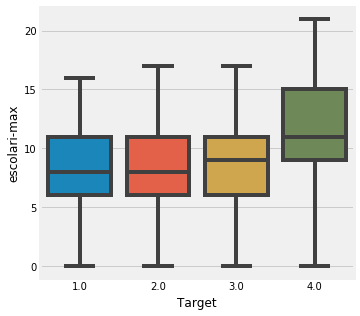

In [51]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='escolari-max', data=final_)

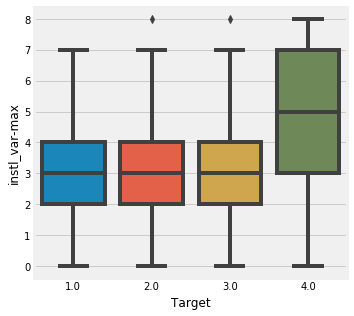

In [52]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='instl_var-max', data=final_)

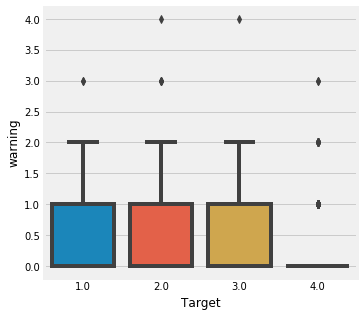

In [53]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='warning', data=final_)

In [54]:
# Finding female head gender
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final_ = final_.merge(head_gender, on='idhogar', how='left').rename(columns={'female': 'female-head'})

In [55]:
# Understanding the
final_.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

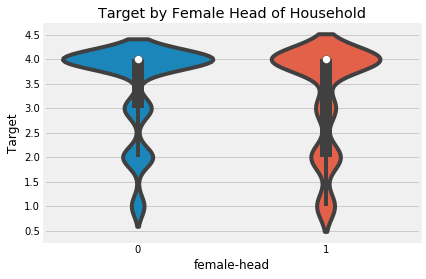

In [56]:
sns.violinplot(x='female-head', y='Target', data=final_);
plt.title('Target by Female Head of Household');

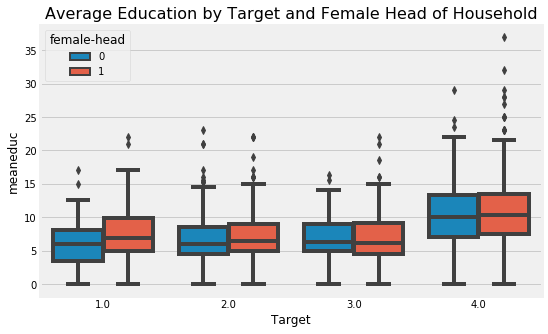

In [57]:
plt.figure(figsize = (8, 5))
sns.boxplot(x='Target', y='meaneduc', hue='female-head', data=final_);
plt.title('Average Education by Target and Female Head of Household', size = 16);

In [58]:
final_.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


Notes:
- Despite females having higher levels of education, we can see that they will have higher less of poverty if they are the head of the household.

## Saving Datasets

In [60]:
final_.to_pickle('./pickles/final.pkl')


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickles
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [4]:
final = pd.read_pickle("./pickles/final.pkl")
test_set = pd.read_pickle("./pickles/test.pkl")
final.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_,female-head
0,0,0,1,1,1,0,0,0,0,0,...,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0,0
1,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0,0
2,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0,1
3,0,0,1,1,1,0,0,0,0,0,...,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0,0
4,1,0,1,1,1,0,0,0,0,0,...,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0,0


In [5]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extracting the training/testing set
train_on = final[final['Target'].notnull()]
train_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

test_on = final[final['Target'].isnull()]
test_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

# Submission base which is used for making submissions to the competition
submission_base = test_set[['Id', 'idhogar']].copy()

/Users/alexguanga/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
# Fixing missing values

features = list(train_on.columns)
pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_on = pipeline.fit_transform(train_on)
test_on = pipeline.transform(test_on)

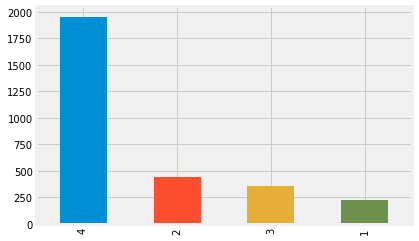

In [7]:
pd.DataFrame({'train_labels': train_labels})['train_labels'].value_counts().plot(kind='bar')

In [8]:
# Quick Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

# 10 fold cross validation
cv_score = cross_val_score(model, train_on, train_labels, cv=10, scoring=scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3405 with std = 0.0395


## Feature Importance

In [9]:
model.fit(train_on, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000812
1,hacapo,0.000377
2,v14a,0.000500
3,refrig,0.002006
4,paredblolad,0.006893


In [10]:
def plot_feature_importances(df, n = 10, threshold = None):
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

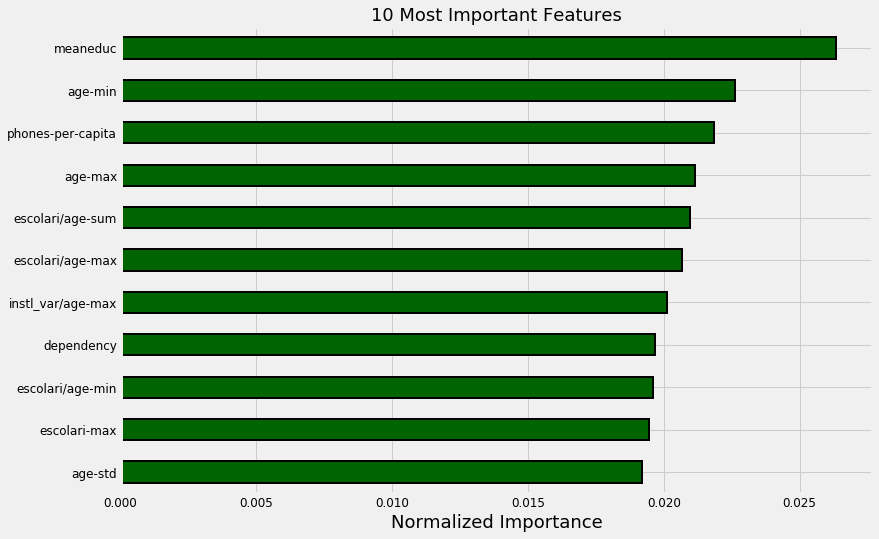

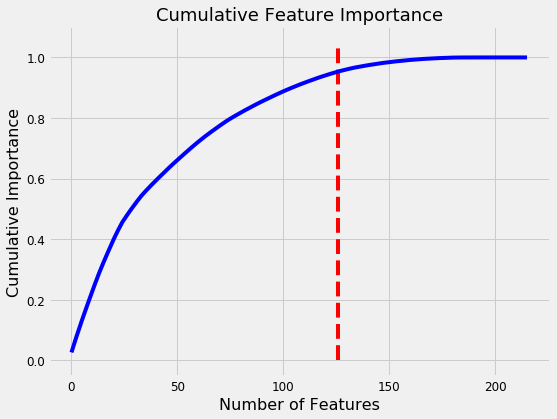

126 features required for 95% of cumulative importance.


In [11]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)


Notes:
- Realize that we do not need all the variable to have a high importance of the data
- Also, the importance does not tell its affect on the target variable
- Lastly, we need to be reassured of the variables that could be correlated with one another.

In [12]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (14, 6))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

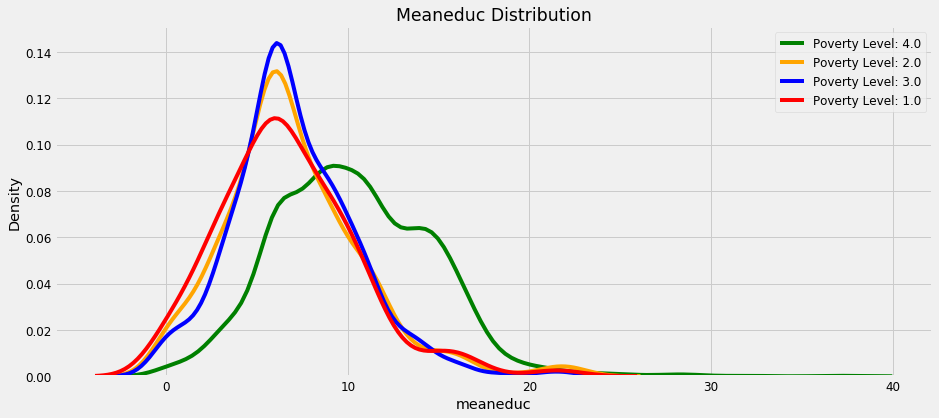

In [13]:
kde_target(final, 'meaneduc')

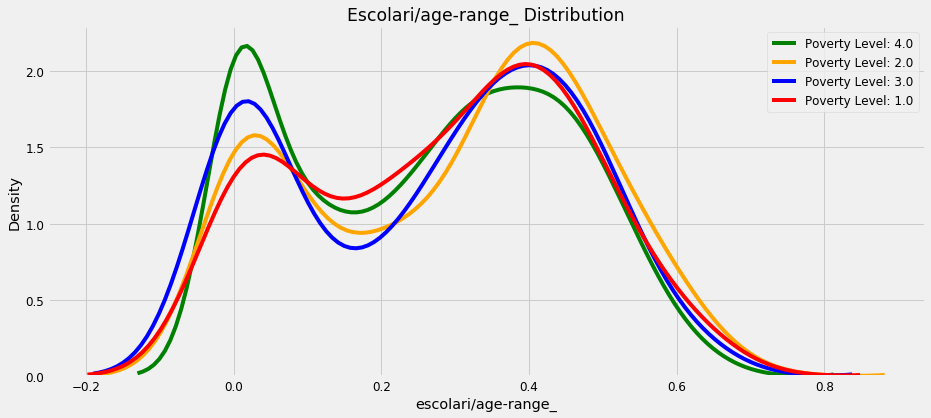

In [14]:
kde_target(final, 'escolari/age-range_')

## Modeling

In [15]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [16]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                           'cv_std': cv_scores.std()},
                                                           index = [0]), ignore_index = True)

        return model_results

In [17]:
# LSVC Model
model_results = cv_model(train_on, train_labels, LinearSVC(), 'LSVC', model_results)

10 Fold CV Score: 0.29043 with std: 0.0491


In [18]:
# Gaussian Model
model_results = cv_model(train_on, train_labels, GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.1958 with std: 0.04638


In [19]:
# The multi-layer perceptron
model_results = cv_model(train_on, train_labels, MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.31322 with std: 0.04772


In [20]:
# If you run LinearDiscriminantAnalysis without filtering out the UserWarnings, you get many messages saying 
# "Variables are collinear." This might give us a hint that we want to remove some collinear features! 

model_results = cv_model(train_on, train_labels, LinearDiscriminantAnalysis(), 'LDA', model_results)

10 Fold CV Score: 0.31704 with std: 0.06514


In [21]:
# Ridge Regression
model_results = cv_model(train_on, train_labels, RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27786 with std: 0.03989


In [22]:
# KNN Model with three parameters
for n in [2, 10, 20]:
    print(f'\nKNN with {n} neighbors')
    model_results = cv_model(train_on, train_labels, KNeighborsClassifier(n_neighbors=n), f'KK-{n}', model_results)
          


KNN with 2 neighbors
10 Fold CV Score: 0.32057 with std: 0.03758

KNN with 10 neighbors
10 Fold CV Score: 0.32686 with std: 0.0315

KNN with 20 neighbors
10 Fold CV Score: 0.31206 with std: 0.0425


In [23]:
# Extra Tree Classifier
model_results = cv_model(train_on, train_labels, ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.32839 with std: 0.04611


In [24]:
# Random Forest Classifier
model_results = cv_model(train_on, train_labels, RandomForestClassifier(100, random_state=10),
                         'RF', model_results)

10 Fold CV Score: 0.34053 with std: 0.0395


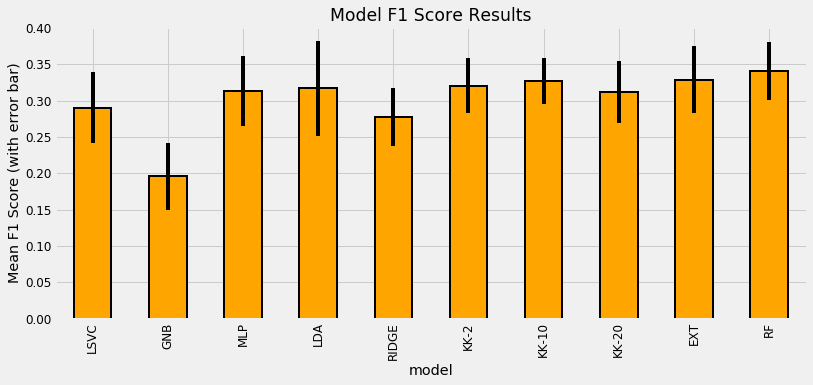

In [25]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (12, 5),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');

In [26]:
# Reseting the index
model_results.reset_index(inplace=True)

## Submission

The submission_base will have all the individuals in the test set since we have to have a "prediction" for each individual while the test_ids will only contain the idhogar from the heads of households. When predicting, we only predict for each household and then we merge the predictions dataframe with all of the individuals on the household id (idhogar). This will set the Target to the same value for everyone in a household. For the test households without a head of household, we can just set these predictions to 4 since they will not be scored.

In [27]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])


In [28]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [29]:
def get_corrs_matrix(data, corr_threshold=.95):
    corr_matrix = data.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(abs(upper[c]) > corr_threshold)]
    return [corr_matrix, to_drop]

In [30]:
# We will continue to remove values that deserve to be removed

train_on = pd.DataFrame(train_on, columns=features)
corr_matrix, to_drop = get_corrs_matrix(train_on)
to_drop

['v18q-count', 'female-sum']

In [31]:
train_on = train_on.drop(to_drop, axis=1)
train_on.shape

(2973, 214)

In [32]:
# Setting up the testing set
test_on = pd.DataFrame(test_on, columns=features)
train_on, test_on = train_on.align(test_on, axis=1, join='inner')
features = list(train_on.columns)

In [33]:
train_on.head(5)

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_,female-head
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.373198,0.000000,0.179402,0.285291,0.000000,0.5,0.045455,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.373198,0.000000,0.268657,0.285291,0.000000,1.0,0.090909,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.373198,0.000000,0.111801,0.285291,0.000000,0.0,0.000000,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.286095,0.399160,0.453782,0.148846,0.185139,1.0,0.363636,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.380759,0.561224,0.367347,0.270829,0.371429,0.5,0.181818,0.0,0.0,0.0


In [34]:
test_on.head(5)

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_,female-head
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.524370,0.592334,0.501742,0.479382,0.507317,0.5,0.136364,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.373198,0.000000,0.305085,0.285291,0.000000,1.0,0.090909,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.373198,0.000000,0.571429,0.285291,0.000000,1.0,0.090909,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.253622,0.227354,0.473684,0.283680,0.231328,1.0,0.181818,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.048292,0.043290,0.857143,0.048309,0.039394,1.0,0.181818,0.0,0.0,1.0


### Improving Models: Recursive Feature Elimination with Random Forest

In [35]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state=10, n_estimators=100,  n_jobs=-1)

# Create the object]
selector = RFECV(estimator, step=1, cv=3, scoring=scorer, n_jobs=-1)

In [36]:
# Fitting the object with the RF model
selector.fit(train_on, train_labels)

RFECV(cv=3,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
   n_jobs=-1, scoring=make_scorer(f1_score, average=macro), step=1,
   verbose=0)

56

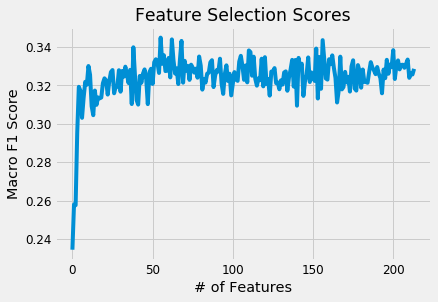

In [37]:
# Plotting the Recursive Feature Elimination
plt.plot(selector.grid_scores_);
plt.xlabel('# of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores')

selector.n_features_

In [38]:
# The ranking of the features
rankings = pd.DataFrame({'feature': train_on.columns.tolist(), 
                        'rank': selector.ranking_.tolist()}).sort_values('rank')
rankings.head(10)

,feature,rank
101,female-std,1
90,rooms-per-capita,1
195,age-sum,1
194,age-max,1
82,walls,1
179,instlevel8-sum,1
122,estadocivil7-std,1
192,escolari-range_,1
88,phones-per-capita,1
48,lugar1,1


In [41]:
# Using the features we obtained, we now have to use to train the model
train_selected = selector.transform(train_on)
test_selected = selector.transform(test_on)

# Converting back into a dataframe
selected_features = train_on.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns=selected_features)
test_selected = pd.DataFrame(test_selected, columns=selected_features)

# Training the model
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.35515 with std: 0.04727


In [42]:
def plot_model_scores(model_results):
    model_results.set_index('model', inplace = True)
    model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6), 
                                      yerr = list(model_results['cv_std']),
                                      edgecolor = 'k', linewidth = 2)

    plt.title('Model F1 Score Results');
    plt.ylabel('Mean F1 Score (with error br)');
    model_results.reset_index(inplace = True)
    

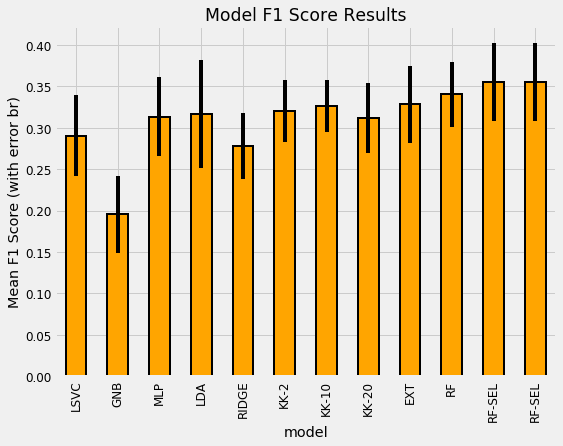

In [43]:
plot_model_scores(model_results)

## Advanced Modeling: Gradient Boosting Machine


From Blog Post:
- Choosing Number of Estimators with Early Stopping
    - To choose the number of estimators (the number of decision trees in the ensemble, called ``n_estimators`` or ``num_boost_rounds``), we'll use early stopping with 5-fold cross validation. This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [44]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

###  Light Gradient Boosting Implementation

From Blog Post:
- Choosing hyperparameters for the Gradient Boosting Machine can be tough and generally is done through model optimization. In this notebook, we'll use a set of hyperparameters that I've found work well on previous problems (although they will not necessarily translate to this competition).
- We set the ``n_estimators`` to 10000 but we won't actually reach this number because we are using ``early stopping`` which will quit training estimators when the cross validation metric does not improve for early_stopping_rounds. There's a lot going on in this function, and read through it carefully to make sure you have it all! I've tried to make the comments and code straightforward. (The display is used to show custom information during training in combination with %%capture so we don't have to see all the LightGBM information during training).

In [45]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds=5, return_preds=False, hyp=None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                  'min_child_samples': 10, 
                  'num_leaves': 36, 'reg_alpha': 0.76, 
                  'reg_lambda': 0.43, 
                  'subsample_for_bin': 40000, 
                  'subsample': 0.54, 
                  'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective='multiclass', n_jobs=-1, 
                               n_estimators=10000, #n_estimators is 10000: large enough to have no affect
                               random_state=10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits=nfolds, shuffle=True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds=100, 
                  eval_metric=macro_f1_score,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_names=['train', 'valid'],
                  verbose=200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

Notes:
- **Cross Validation with Early Stopping Notes**
    - Cross validation with early stopping is one of the most effective methods for preventing overfitting on the training set because it prevents us from continuing to add model complexity once it is clear that validation scores are not improving. Repeating this process across multiple folds helps to reduce the bias that comes from using a single fold. Early stopping also lets us train the model much quicker. 

In [46]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_on, train_labels, test_on, test_ids, return_preds=True)

'Fold 1, Validation Score: 0.43377, Estimators Trained: 5'

'Fold 2, Validation Score: 0.38767, Estimators Trained: 96'

'Fold 3, Validation Score: 0.43074, Estimators Trained: 89'

'Fold 4, Validation Score: 0.41656, Estimators Trained: 26'

'Fold 5, Validation Score: 0.40442, Estimators Trained: 192'

'5 cross validation score: 0.41463 with std: 0.01709.'

In [47]:
predictions.head()

,1,2,3,4,idhogar,fold,Target,confidence
0,0.244063,0.243761,0.243341,0.268834,72958b30c,1,4,0.268834
1,0.243828,0.243621,0.243201,0.269351,5b598fbc9,1,4,0.269351
2,0.246444,0.246730,0.246642,0.260184,1e2fc704e,1,4,0.260184
3,0.245319,0.240415,0.249421,0.264846,8ee7365a8,1,4,0.264846
4,0.243899,0.243598,0.243178,0.269325,ff69a6fc8,1,4,0.269325


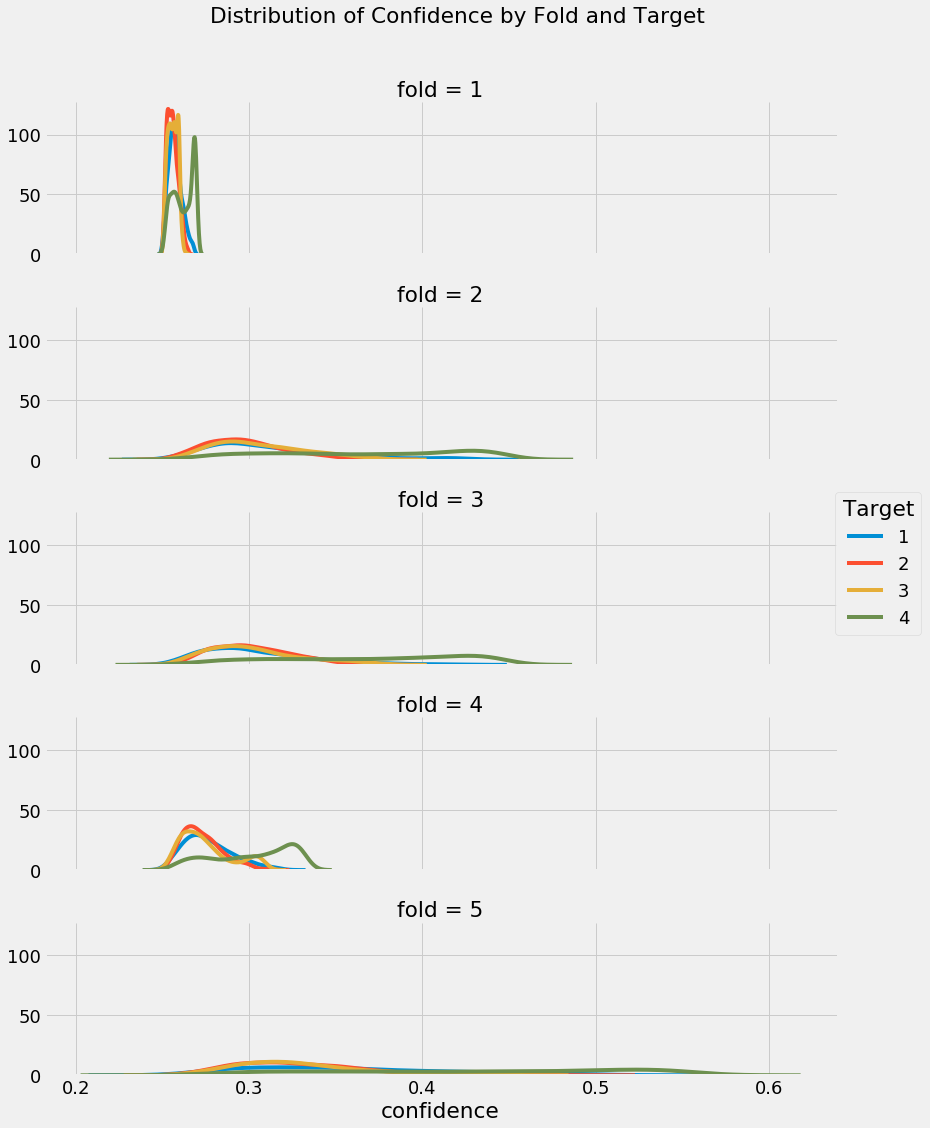

In [48]:
# Plotting the confidence, or highest probability, of each of the target
# for each of the folds
plt.rcParams['font.size'] = 18

# Kdeplot
g = sns.FacetGrid(predictions, row='fold', hue='Target', size=3, aspect=4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();

plt.suptitle('Distribution of Confidence by Fold and Target', y = 1.05);

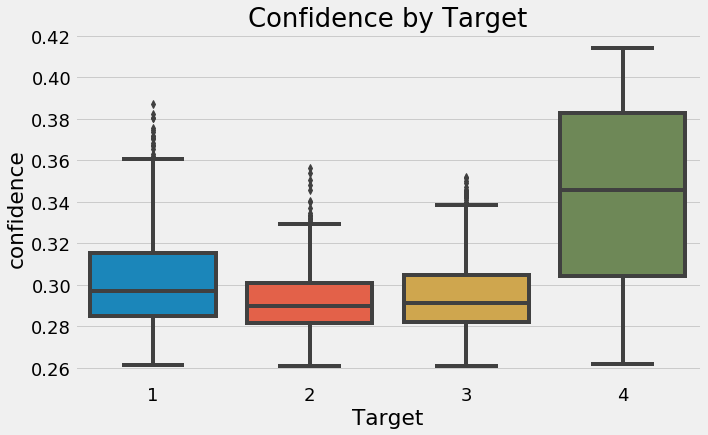

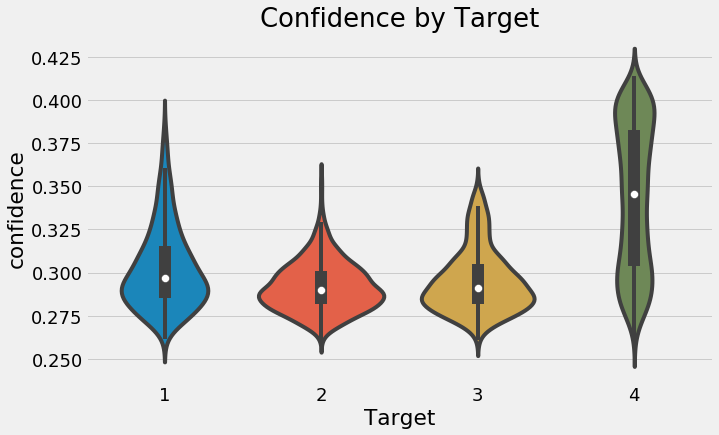

In [49]:
# Currently, our data is inbalanced, Target 4 has the mose values 
# Note, why is the target 4 the most frequent target, wasn't it target 1? did the values changes?

predictions = predictions.groupby('idhogar', as_index=False).mean()

# Getting the target index with the highest prob
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis=1)

# Getting the target value with the highest prob
predictions['Confidence'] = predictions[[1, 2, 3, 4]].max(axis=1)

# Removing the specific fold
predictions.drop('fold', axis=1, inplace=True)

# Plotting the confidence by eachh target
plt.figure(figsize = (10, 6))
sns.boxplot(x='Target', y='confidence', data=predictions);
plt.title('Confidence by Target');

plt.figure(figsize = (10, 6))
sns.violinplot(x='Target', y='confidence', data=predictions);
plt.title('Confidence by Target');

In [50]:
predictions.head(5)

,idhogar,1,2,3,4,Target,confidence,Confidence
0,000a08204,0.196577,0.220680,0.220486,0.362257,4,0.362257,0.362257
1,000bce7c4,0.276039,0.234840,0.255026,0.234095,1,0.276039,0.276039
2,001845fb0,0.191982,0.200592,0.209113,0.398313,4,0.398313,0.398313
3,003514e22,0.189918,0.224097,0.242085,0.343900,4,0.343900,0.343900
4,003b51a87,0.305988,0.270413,0.216259,0.207340,1,0.305988,0.305988


Notes:
- We can have the function instead return the actual submission file. This takes the average predictions across the five folds, in effectm combining 5 different models, each one trained on a slghtly different subset of the data.

In [51]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, 
                                             test_on, test_ids, return_preds=False)

submission.to_csv('gbm_baseline.csv')

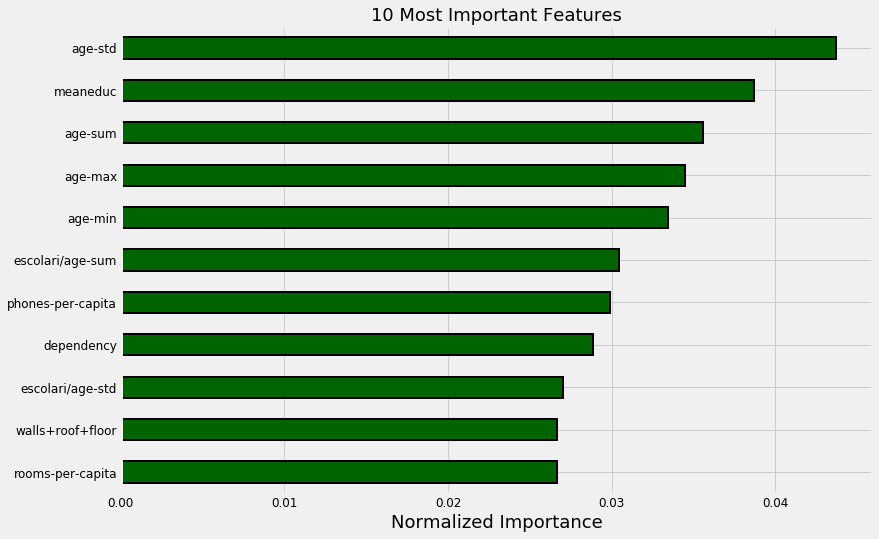

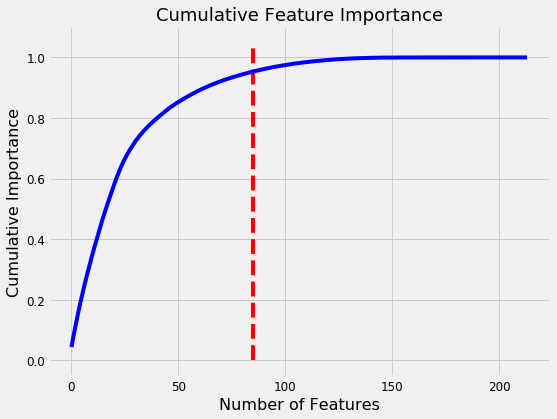

85 features required for 95% of cumulative importance.


In [52]:
_ = plot_feature_importances(gbm_fi, threshold=0.95)

In [53]:
%%capture --no-display
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids)


'Fold 1, Validation Score: 0.39746, Estimators Trained: 379'

'Fold 2, Validation Score: 0.40452, Estimators Trained: 14'

'Fold 3, Validation Score: 0.42086, Estimators Trained: 22'

'Fold 4, Validation Score: 0.41857, Estimators Trained: 16'

'Fold 5, Validation Score: 0.42215, Estimators Trained: 10'

'5 cross validation score: 0.41271 with std: 0.0099.'

In [54]:
# Append the result of previous to our dictionary
model_results = model_results.append(pd.DataFrame({'model': ["GBM", "GBM_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}),
                                     sort = True)

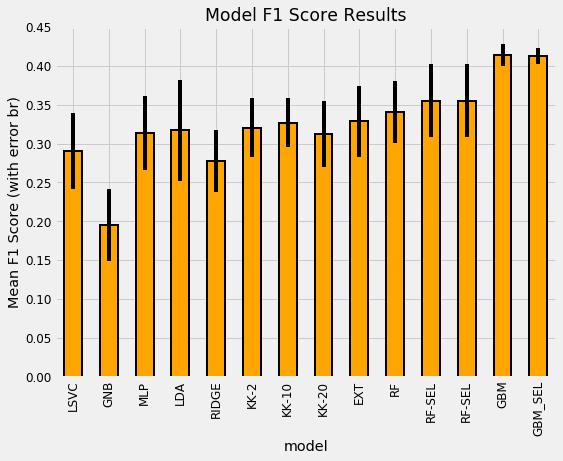

In [55]:
# Plotting the performance of our models
plot_model_scores(model_results)

In [56]:
# Making the model a 10-fold

In [57]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, test_on, test_ids, 
                                             nfolds=10, return_preds=False)

In [58]:
submission.to_csv('gbm_10fold.csv', index=False)

In [59]:
%%capture
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids,
                                                               nfolds=10)

In [60]:
submission.to_csv('gmb_10fold_selected.csv', index = False)

In [61]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_10Fold", "GBM_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}),
                                    sort = True)

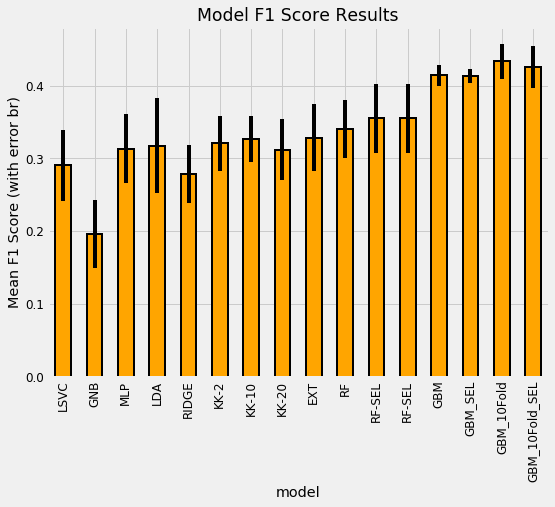

In [62]:
plot_model_scores(model_results)

Notes:
- The best model seems to be the Gradient Boosting Machine trained with 10 folds on the selected features. This model has not yet been optimized, but we might be able to get a little more performance through optimization.

In [63]:
print(f"There are {gbm_fi_selected[gbm_fi_selected['importance'] == 0].shape[0]} features with no importance.")

There are 0 features with no importance.


Notes:
- All of the features we are using have some importance to the Gradient Boosting Machine. It might be a good idea to go back and retry feature selection but with the GBM since that is the model we are using.

## Model Optimizations: Automated Optimization

Bayesian optimization requires 4 parts:

1. Objective function: what we want to maximize (or minimize)
2. Domain space: region over which to search
3. Algorithm for choosing next hyperparameters: uses past results to suggest next values
4. Results history: saves the past results

In [64]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

import csv
import ast
from timeit import default_timer as timer

### 1. Objective Function


In [65]:
def objective(hyperparameters, nfolds=5):
    """Return validation score from hyperparameters for LightGBM"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    subsample_freq = hyperparameters['boosting_type'].get('subsample_freq', 0)
    
    boosting_type = hyperparameters['boosting_type']['boosting_type']
    
    if boosting_type == 'dart':
        hyperparameters['drop_rate'] = hyperparameters['boosting_type']['drop_rate']
    
    # Subsample and subsample frequency to top level keys
    hyperparameters['subsample'] = subsample
    hyperparameters['subsample_freq'] = subsample_freq
    hyperparameters['boosting_type'] = boosting_type
    
    # Whether or not to use limit maximum depth
    if not hyperparameters['limit_max_depth']:
        hyperparameters['max_depth'] = -1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'num_leaves', 'subsample_for_bin', 
                           'min_child_samples', 'subsample_freq']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Convert to arrays for indexing
    features = np.array(train_selected)
    labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    model = lgb.LGBMClassifier(**hyperparameters, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None',
                               n_estimators=10000)
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        start = timer()
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        end = timer()
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    hyperparameters['n_estimators'] = estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()
    
    # Display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

### 2. Search Space

In [66]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

In [67]:
sample(space)

{'boosting_type': {'boosting_type': 'goss',
  'subsample': 1.0,
  'subsample_freq': 0},
 'colsample_bytree': 0.5709365274312216,
 'learning_rate': 0.031697939669080015,
 'limit_max_depth': False,
 'max_depth': 9.0,
 'min_child_samples': 40.0,
 'num_leaves': 15.0,
 'reg_alpha': 0.21485206223069397,
 'reg_lambda': 0.23618753936058567,
 'subsample_for_bin': 14000.0}

### 3. Algorithm

The algorithm for choosing the next values is the Tree Parzen Estimator which uses Bayes rule for constructing a surrogate model of the objective function. Instead of maximizing the objective function, the algorithm maximizes the Expected Improvement (EI) of the surrogate model.

In [68]:
algo = tpe.suggest

### 4. Results History

We'll use two different methods for recording results:
- Trials object: stores everything returned from the objective function
- Write to a csv file on every iteration


I like using multiple methods for tracking progress because it means redundancy. One way may fail, but hopefully both will not! The csv file can be used to monitor the method while it is running and the Trials object can be saved and then reloaded to resume optimization.

In [69]:
# Record results
trials = Trials()

# Create a file and open a connection
OUT_FILE = 'optimization.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS = 5
ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score', 'std']
writer.writerow(headers)
of_connection.close()

In [74]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Run optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS)

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.4263.'

'Iteration: 20, Current Score: 0.4336.'

'Iteration: 30, Current Score: 0.4213.'

'Iteration: 40, Current Score: 0.4313.'

'Iteration: 50, Current Score: 0.4327.'

'Iteration: 60, Current Score: 0.4247.'

'Iteration: 70, Current Score: 0.4287.'

'Iteration: 80, Current Score: 0.4273.'

'Iteration: 90, Current Score: 0.4455.'

'Iteration: 100, Current Score: 0.4445.'

In [75]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(str(trials)))


In [76]:
results = pd.read_csv(OUT_FILE).sort_values('loss', ascending=True).reset_index()
results.head()

,index,loss,hyperparameters,iteration,runtime,score,std
0,61,0.547587,"{'boosting_type': 'dart', 'colsample_bytree': ...",62,10.730562,0.452413,0.013249
1,89,0.554535,"{'boosting_type': 'dart', 'colsample_bytree': ...",90,9.294802,0.445465,0.020549
2,31,0.555021,"{'boosting_type': 'dart', 'colsample_bytree': ...",32,4.702208,0.444979,0.014372
3,99,0.555531,"{'boosting_type': 'dart', 'colsample_bytree': ...",100,11.478803,0.444469,0.021118
4,65,0.556293,"{'boosting_type': 'goss', 'colsample_bytree': ...",66,0.996220,0.443707,0.022137


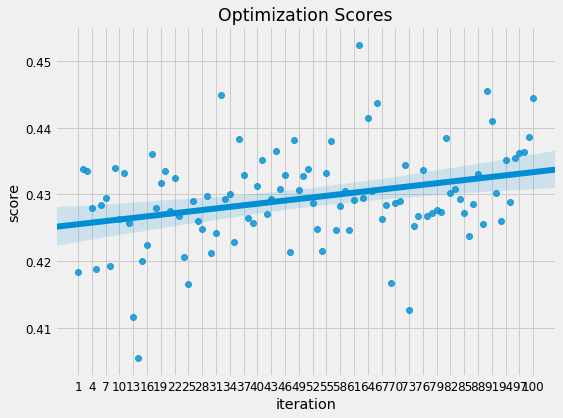

In [77]:
plt.figure(figsize = (8, 6))
sns.regplot('iteration', 'score', data = results);
plt.title("Optimization Scores");
plt.xticks(list(range(1, results['iteration'].max() + 1, 3)));

In [78]:
best_hyp = ast.literal_eval(results.loc[0, 'hyperparameters'])
best_hyp

{'boosting_type': 'dart',
 'colsample_bytree': 0.6656610653879056,
 'learning_rate': 0.15654386057087114,
 'limit_max_depth': False,
 'max_depth': -1,
 'min_child_samples': 25,
 'num_leaves': 28,
 'reg_alpha': 0.34028648714401466,
 'reg_lambda': 0.4969925318931504,
 'subsample_for_bin': 60000,
 'drop_rate': 0.39401307778070693,
 'subsample': 0.9522476606817002,
 'subsample_freq': 6,
 'n_estimators': 86}

In [83]:
%%capture
sub_gbm_opt_10fold_sel, gbm_fi_opt_10fold_sel, valid_scores = model_gbm(train_selected, train_labels, 
                                             test_selected, test_ids, 
                                             nfolds=10, hyp=best_hyp, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [80]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, 
                                             test_on, test_ids, 
                                             nfolds=10, hyp=best_hyp, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)


In [84]:
model_results.head(10)

,cv_mean,cv_std,model
14,0.433122,0.024496,GBM_10Fold
15,0.425541,0.029268,GBM_10Fold_SEL
0,0.417161,0.028835,GBM_OPT_10Fold_SEL
0,0.414255,0.036250,GBM_OPT_10Fold
12,0.414023,0.014316,GBM
13,0.412712,0.009896,GBM_SEL
0,0.399565,0.032698,GBM_OPT_10Fold_SEL
11,0.355147,0.047267,RF-SEL
10,0.355147,0.047267,RF-SEL
9,0.340525,0.039503,RF


In [85]:
sub_gbm_opt_10fold_sel.to_csv('gbm_opt_10fold_selected.csv', index=False)

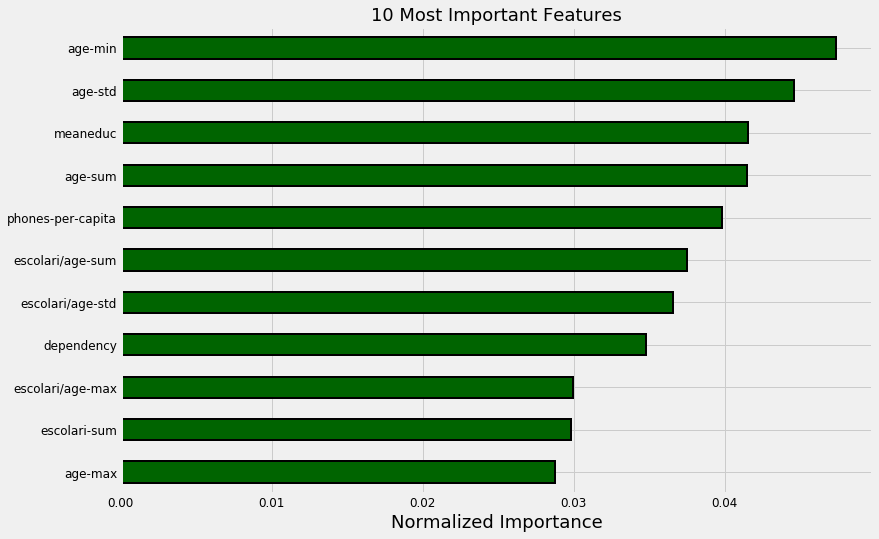

In [86]:
_ = plot_feature_importances(gbm_fi_opt_10fold_sel)

In [94]:
# Comparing the target variables across the training and testing set
preds = submission_base.merge(sub_gbm_opt_10fold_sel, on='Id', how='left')
preds = pd.DataFrame(preds.groupby('idhogar')['Target'].mean())
preds.shape

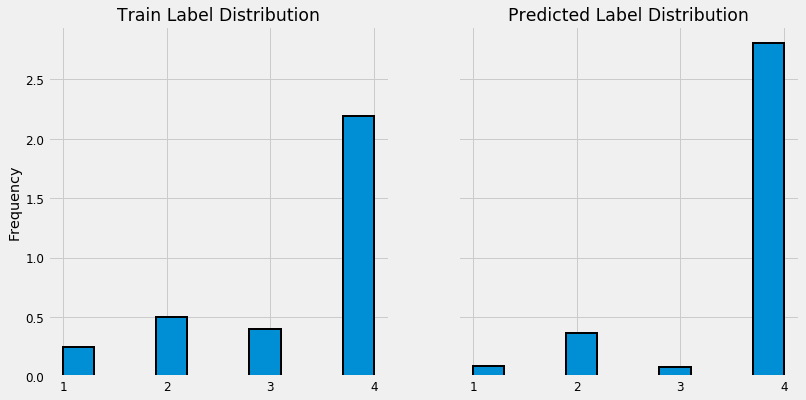

In [89]:
# Plot the training labels distribution
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
final['Target'].sort_index().plot.hist(normed = True,
                                       edgecolor = r'k',
                                       linewidth = 2,
                                       ax = axes[0])

axes[0].set_xticks([1, 2, 3, 4]);
axes[0].set_title('Train Label Distribution')

# Plot the predicted labels
preds['Target'].sort_index().plot.hist(normed = True, 
                                       edgecolor = 'k',
                                       linewidth = 2,
                                       ax = axes[1])
axes[1].set_xticks([1, 2, 3, 4]);
plt.subplots_adjust()
plt.title('Predicted Label Distribution');

In [100]:
final['Target'].value_counts()

4.0    1954
2.0     442
3.0     355
1.0     222
Name: Target, dtype: int64

In [101]:
preds['Target'].value_counts()

4    6187
2     820
1     180
3     165
Name: Target, dtype: int64

Notes:
- The predicted distribution looks close to the training distribution although there are some differences. Depending on the run of the notebook, the results you see may change, but for this edition, the 4s are underrepresented in the predictions and the 3s are overrepresented.
- One potentially method for dealing with imbalanced classification problems is oversampling the minority class, which is easy to do in Python using the imbalanced learn library. We won't explore that option here.

## Model Optimization: Train on the Validation Set

In [102]:
from sklearn.model_selection import train_test_split

# Split into validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_selected,
                                                      train_labels,
                                                      test_size = 1000,
                                                      random_state = 10)

# Create model and train
model = lgb.LGBMClassifier(**best_hyp, 
                           class_weight = 'balanced',
                           random_state = 10)
model.fit(X_train, y_train);

In [103]:
# Make validation predictions
valid_preds = model.predict_proba(X_valid)
preds_df = pd.DataFrame(valid_preds, columns = [1, 2, 3, 4])

# Convert into predictions
preds_df['prediction'] = preds_df[[1, 2, 3, 4]].idxmax(axis = 1)
preds_df['confidence'] = preds_df[[1, 2, 3, 4]].max(axis = 1)

preds_df.head()

,1,2,3,4,prediction,confidence
0,0.092974,0.070449,0.048534,0.788043,4,0.788043
1,0.030688,0.034598,0.026426,0.908289,4,0.908289
2,0.040777,0.111144,0.390535,0.457544,4,0.457544
3,0.217870,0.409564,0.289867,0.082700,2,0.409564
4,0.058482,0.225054,0.600872,0.115592,3,0.600872


In [104]:
print('F1 score:', round(f1_score(y_valid, preds_df['prediction'], average = 'macro'), 5))


F1 score: 0.43528


In [105]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 26  18  17  19]
 [ 23  53  30  33]
 [ 13  24  38  38]
 [ 19  69  80 500]]


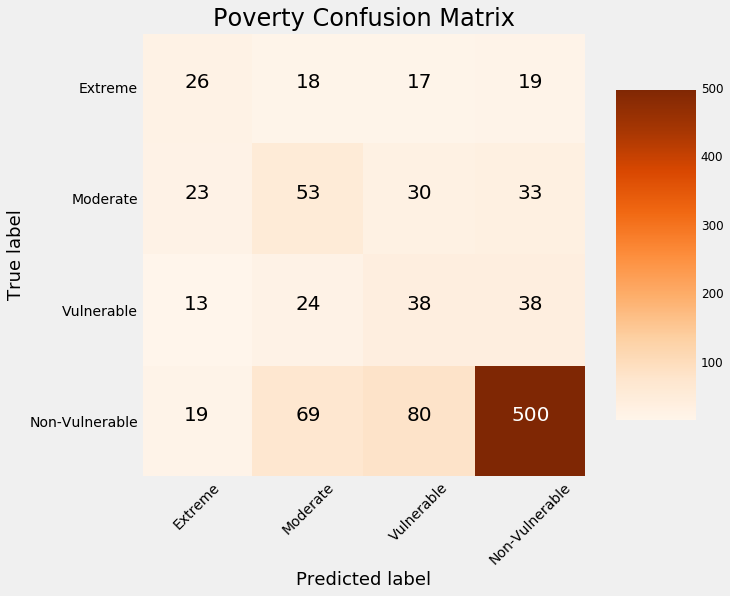

In [106]:
cm = confusion_matrix(y_valid, preds_df['prediction'])

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

Notes:
- Any values in the diagnoal are responses we got right. Any value not on the diagnol can be disected by viewing the true and what we predicted!

Normalized confusion matrix
[[0.325      0.225      0.2125     0.2375    ]
 [0.16546763 0.38129496 0.21582734 0.23741007]
 [0.11504425 0.21238938 0.33628319 0.33628319]
 [0.02844311 0.10329341 0.11976048 0.74850299]]


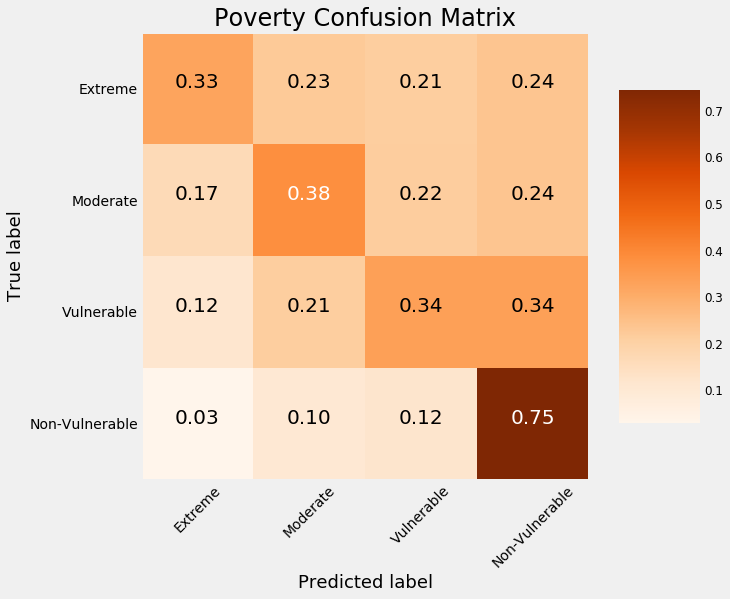

In [107]:
plot_confusion_matrix(cm, normalize = True,
                      classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

Notes:
- Now we can see that our model really does not do that well for classes other than Non Vulnerable.
- Overall, these results show that imbalanced classification problems with relatively few observations are very difficult. There are some methods we can take to try and counter this such as oversampling or training multiple models on different sections of the data, but at the end of the day, the most effective method may be to gather more data.

In [109]:
# Saving Models for advances techniques
train_selected.to_pickle('./pickles/train_selected.pkl')
test_selected.to_pickle('./pickles/test_selected.pkl')